In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from AggregateStatisticCalculator import AggregateStatisticCalculator

Initialize the statistic calculator for load factor and download the sample statistics for each

In [2]:
asc = AggregateStatisticCalculator('kitobo','minute','loadFactor')
asc.connect()
lfs = asc.getSamplesByNumberUsers()
asc.disconnect()

Make the box and whisker density plot by number of users. Note how the load factor approaches an upper limit, and how the variation shrinks

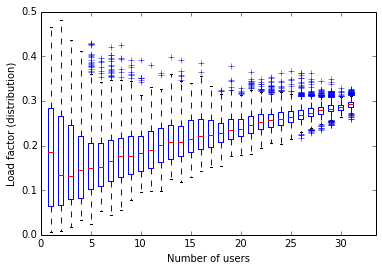

In [3]:
plt.figure()
plt.boxplot(lfs)
plt.xlabel('Number of users')
plt.ylabel('Load factor (distribution)')
plt.xticks(np.arange(0,len(lfs),5));

Repeat for coefficient of variation in the load

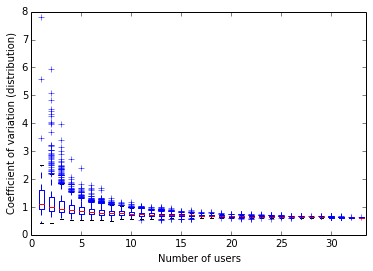

In [4]:
asc = AggregateStatisticCalculator('kitobo','minute','cov')
asc.connect()
covs = asc.getSamplesByNumberUsers()
asc.disconnect()
plt.figure()
plt.boxplot(covs)
plt.xlabel('Number of users')
plt.ylabel('Coefficient of variation (distribution)')
plt.xticks(np.arange(0,len(lfs),5));